# REINFORCE in PyTorch (easy part)

In [ ]:
# import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
#     !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
#     !pip install -q gymnasium
#     !pip install moviepy
#     !apt install ffmpeg
#     !pip install imageio-ffmpeg
#     !touch .setup_complete

# # This code creates a virtual display to draw game images on.
# # It will have no effect if your machine has a monitor.
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash ../xvfb start
#     os.environ['DISPLAY'] = ':1'

# also you need to install ffmpeg if not installed
# for MacOS: ! brew install ffmpeg

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

2 4


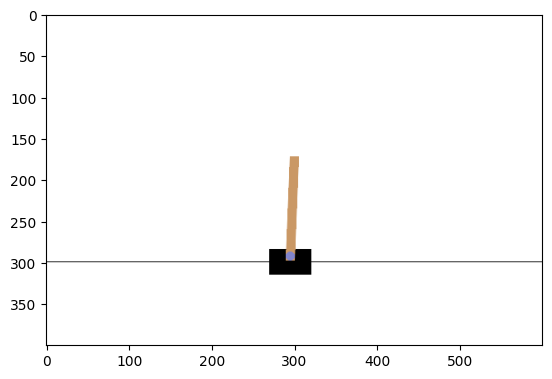

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
print(n_actions, state_dim)

plt.imshow(env.render())

# Построение сети для REINFORCE

Для алгоритма REINFORCE нам понадобится модель, которая по состоянию предсказывает вероятности действий.

Для численной стабильности, пожалуйста, не включайте слой softmax в архитектуру сети.
Мы будем применять softmax или log-softmax там, где это будет уместно.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Постройте простую нейросеть, которая предсказывает логиты политики.
# Оставьте её простой: для CartPole нет смысла делать глубокие архитектуры.
model = nn.Sequential(
  # <ВАШ КОД: определите нейросеть, предсказывающую логиты политики>
  nn.Linear(state_dim, 128),
  nn.ReLU(),
  nn.Linear(128, n_actions)
)

## Предсказание

Замечание: выходное значение этой функции — не тензор torch, а массив numpy.
Поэтому здесь вычисление градиентов не требуется.

Используйте no_grad, чтобы выключить вычисление градиента.

Также можно использовать .detach() (или устаревший .data), но есть различие:

- При .detach() вычислительный граф всё равно строится, но затем связь с конкретным тензором обрывается. Поэтому .detach() стоит применять тогда, когда граф всё ещё нужен для обратного прохода через какой-то другой (не отделённый) тензор.
- В отличие от этого, внутри контекста no_grad() граф вообще не строится для любых операций. Поэтому в данном случае предпочтительнее использовать именно no_grad().

In [ ]:
def predict_probs(states):
    """
    Предсказывает вероятности действий для заданных состояний.
    :param states: numpy-массив формы [batch, state_shape]
    :returns: numpy-массив формы [batch, n_actions]
    """
    # преобразуем состояния в тензор, считаем логиты, применяем softmax для получения вероятностей
    # <ВАШ КОД>
    # return <ВАШ КОД>
    states_t = torch.tensor(states, dtype=torch.float32)

    with torch.no_grad():                        # отключаем вычисление градиентов
        logits = model(states_t)                 # форма [batch, n_actions]
        probs = F.softmax(logits, dim=-1)         # преобразуем логиты в вероятности
    return probs.cpu().numpy()                   # возвращаем как numpy-массив

In [ ]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

### Play the game: собираем опыт в среде

Теперь мы можем использовать нашего только что созданного агента, чтобы сыграть в игру.

In [ ]:
def generate_session(env, t_max=1000):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()[0]

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s])).squeeze()

        # Sample action with given probabilities.
        # a = <ВАШ КОД>
        a = np.random.choice(env.action_space.n, p=action_probs)

        new_s, r, terminated, truncated, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if terminated or truncated:
            break

    return states, actions, rewards

In [ ]:
# test it
states, actions, rewards = generate_session(env)

### Вычисляем кумулятивные награды

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [ ]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    # <ВАШ КОД>
    # return <ВАШ КОД: array of cumulative rewards>

    n = len(rewards)
    G = np.zeros(n, dtype=np.float32)
    G_t = 0.0
    for i in reversed(range(n)):
        G_t = rewards[i] + gamma * G_t
        G[i] = G_t
    return G

In [ ]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

Теперь нам нужно определить функцию потерь и обновление параметров для градиентного метода по политике (policy gradient).

Наша целевая функция (objective):

$$J \approx \frac{1}{N} \sum_{i=1}^{N} G(s_i, a_i)$$

REINFORCE даёт способ вычисления градиента матожидания вознаграждения по параметрам политики \theta:

$$\nabla_\theta \hat J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G(s_i, a_i)$$

То есть, мы берём логарифм вероятности выбранного действия, умножаем на накопленное вознаграждение, и считаем градиент по параметрам сети.

С помощью PyTorch это можно сделать через обычное определение функции потерь:

$$\hat J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \log \pi_\theta (a_i \mid s_i) \cdot G(s_i, a_i)$$

При вычислении градиента этой функции по весам сети $\theta$ PyTorch автоматически выдаст правильный градиент политики, как описано в REINFORCE.

In [ ]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * F.one_hot(actions, env.action_space.n), dim=1)

    # Compute loss here. Don't forgen entropy regularization with `entropy_coef`
    # entropy = <ВАШ КОД>
    # Entropy regularization: средняя энтропия по шагам
    entropy = - torch.sum(probs * log_probs, dim=-1).mean()

    # loss = <ВАШ КОД>
    # Policy gradient loss: мы хотим MAXIMIZE mean(log_pi * G),
    # поэтому для оптимизации методом градиентного спуска берем минус этого.
    loss = -torch.mean(log_probs_for_actions * cumulative_returns) - entropy_coef * entropy

    # Gradient descent step
    # <ВАШ КОД>
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [ ]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions

    print("mean reward: %.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward: 19.500
mean reward: 13.750
mean reward: 15.370
mean reward: 28.100
mean reward: 63.590
mean reward: 89.860
mean reward: 153.000
mean reward: 182.910
mean reward: 152.750
mean reward: 187.920
mean reward: 163.910
mean reward: 171.140
mean reward: 297.040
mean reward: 272.770
mean reward: 209.400
mean reward: 257.390
mean reward: 116.130
mean reward: 122.560
mean reward: 149.560
mean reward: 203.070
mean reward: 210.330
mean reward: 322.930
mean reward: 141.980
mean reward: 257.850
mean reward: 112.830
mean reward: 102.890
mean reward: 152.900
mean reward: 174.180
mean reward: 162.570
mean reward: 102.310
mean reward: 89.790
mean reward: 105.240
mean reward: 130.300
mean reward: 106.110
mean reward: 117.060
mean reward: 273.710
mean reward: 162.600
mean reward: 173.110
mean reward: 955.070
You Win!


### Results & video

In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with gym.make("CartPole-v1", render_mode="rgb_array") as env, RecordVideo(
    env=env, video_folder="./videos"
) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(10)]


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Implementing Actor Critic (A2C)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from collections import deque

class ActorBatch:
    def __init__(self):
        self.logprobs = []
        self.q_values = []

    def append(self, log_prob, q_value):
        self.logprobs.append(log_prob)
        self.q_values.append(q_value)

    def clear(self):
        self.logprobs.clear()
        self.q_values.clear()

def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer [(s, a, r, n_s, done)]
    # and split an array of samples into arrays: states, actions, rewards, next_actions, terminateds
    # <ВАШ КОД>
    n_samples = min(len(replay_buffer), n_samples)

    indices = np.random.choice(len(replay_buffer), n_samples, replace=False)
    states, actions, rewards, next_actions, terminateds = [], [], [], [], []
    for i in indices:
        s, a, r, n_s, done = replay_buffer[i]
        states.append(s)
        actions.append(a)
        rewards.append(r)
        next_actions.append(n_s)
        terminateds.append(done)
    ##############################

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_actions), np.array(terminateds)

In [ ]:
class ActorCriticModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()

        # Инициализируйте сеть агента с двумя головами: softmax-актора и линейного критика
        # self.net, self.actor_head, self.critic_head =
        ####### <ВАШ КОД> ########
        from_dim = input_dim
        layers = []
        for to_dim in hidden_dims:
            layers.extend([
                nn.Linear(from_dim, to_dim),
                nn.Tanh()
            ])
            from_dim = to_dim

        self.net = nn.Sequential(*layers)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
        )
        # self.actor_head = nn.Sequential(
        #     create_network(input_dim, hidden_dims, output_dim),
        #     nn.Softmax(dim=-1)
        # )
        # self.critic_head = create_network(input_dim, hidden_dims, output_dim)
        ##############################

    def forward(self, state):
        # Вычислите выбранное действие, логарифм вероятности его выбора и соответствующее значение Q-функции
        ####### <ВАШ КОД> ########
        state = self.net(state)

        action_probs = self.actor_head(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        q_values = self.critic_head(state)

        log_prob = dist.log_prob(action)
        action = action.item()
        # adv = q_values[action] - torch.sum(q_values * action_probs, -1)
        q_value = q_values[action]
        ##############################

        return action, log_prob, q_value

    def evaluate(self, state):
        # Вычислите значения Q-функции для данного состояния
        ####### <ВАШ КОД> ########
        state = self.net(state)

        q_values = self.critic_head(state)
        ##############################
        return q_values

In [ ]:
class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_dims, lr, gamma, critic_rb_size):
        self.lr = lr
        self.gamma = gamma

        # Инициализируйте модель актор-критика и оптимизатор (например, `torch.optim.Adam)`)
        ####### <ВАШ КОД> ########
        self.actor_critic = ActorCriticModel(state_dim, hidden_dims, action_dim)
        self.actor_opt = self.critic_opt = self.opt = torch.optim.Adam(self.actor_critic.parameters(), lr=lr)
        # self.actor_opt = torch.optim.Adam(self.actor_critic.actor_head.parameters(), lr=lr)
        # self.critic_opt = torch.optim.Adam(self.actor_critic.critic_head.parameters(), lr=lr*.25)
        ##############################

        self.actor_batch = ActorBatch()
        self.critic_rb = deque(maxlen=critic_rb_size)

    def act(self, state):
        # Произведите выбор действия и сохраните необходимые данные в батч для последующего обучения
        # Не забудьте сделать q_value.detach()
        # self.actor_batch.append(..)
        ####### <ВАШ КОД> ########
        action, logprob, q_value = self.actor_critic(to_tensor(state))
        self.actor_batch.append(logprob, q_value.detach())

        # action = select_action_eps_greedy(self.actor_critic.critic_head, state, 0.05)
        ##############################

        return action

    def append_to_replay_buffer(self, s, a, r, next_s, terminated):
        # Добавьте новый экземпляр данных в память прецедентов.
        ####### <ВАШ КОД> ########
        self.critic_rb.append((s, a, r, next_s, terminated))
        ##############################

    def evaluate(self, state):
        return self.actor_critic.evaluate(state)

    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)

    def update_actor(self):
        Q_s_a = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs)

        # Реализуйте шаг обновления актора — вычислите ошибку `loss` и произведите шаг обновления градиентным спуском.
        # Опционально: сделайте нормализацию отдач
        ####### <ВАШ КОД> ########
        # Нормализация отдач
        Q_s_a = (Q_s_a - Q_s_a.mean()) / (Q_s_a.std() + 1e-7)

        # Считаем ошибку
        loss = torch.mean(-logprobs * Q_s_a)

        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        self.actor_batch.clear()
        ##############################

    def update_critic(self, batch_size, n_updates=1):
        # Реализуйте n_updates шагов обучения критика.
        ####### <ВАШ КОД> ########

        if len(self.critic_rb) < batch_size:
            return

        for _ in range(n_updates):
            train_batch = sample_batch(self.critic_rb, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch

            self.critic_opt.zero_grad()
            loss = self.compute_td_loss(states, actions, rewards, next_states, terminateds)
            loss.backward()
            self.critic_opt.step()
        ##############################

    def compute_td_loss(
        self, states, actions, rewards, next_states, terminateds, regularizer=.1
    ):
        # переводим входные данные в тензоры
        s = to_tensor(states)                     # shape: [batch_size, state_size]
        a = to_tensor(actions, int).long()        # shape: [batch_size]
        r = to_tensor(rewards)                    # shape: [batch_size]
        s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
        term = to_tensor(terminateds, bool)       # shape: [batch_size]

        # получаем Q[s, a] для выбранных действий в текущих состояниях (для каждого примера из батча)
        # Q_s_a = ...
        ####### <ВАШ КОД> ########
        Q_s = self.evaluate(s)   # shape: [batch_size, n_actions]
        Q_s_a = torch.gather(
            Q_s, dim=1, index=torch.unsqueeze(a, 1)
        ).squeeze(1)
        ##############################

        # получаем Q[s_next, *] — значения полезности всех действий в следующих состояниях
        # Q_sn = ...,
        # а затем вычисляем V*[s_next] — оптимальные значения полезности следующих состояний
        # V_sn = ...
        ####### <ВАШ КОД> ########
        with torch.no_grad():
            Q_sn = self.evaluate(s_next)
            V_sn, _ = torch.max(Q_sn, axis=-1)
        ##############################

        # вычисляем TD target и далее TD error
        # target = ...
        # td_error = ...
        ####### <ВАШ КОД> ########
        target = r + self.gamma * V_sn * torch.logical_not(term)
        td_error = Q_s_a - target
        ##############################

        # MSE loss для минимизации
        loss = torch.mean(td_error ** 2)
        # добавляем регуляризацию на значения Q
        loss += regularizer * Q_s_a.mean()
        return loss

In [ ]:
def run_actor_critic(
        env_name="CartPole-v1",
        hidden_dims=(128, 128), lr=1e-3,
        total_max_steps=200_000,
        # train_schedule=4, replay_buffer_size=4, batch_size=4, critic_updates_per_actor=1,
        train_schedule=32, replay_buffer_size=5000, batch_size=32, critic_updates_per_actor=4,
        eval_schedule=1000, smooth_ret_window=5, success_ret=200.
):
    env = gym.make(env_name)
    episode_return_history = deque(maxlen=smooth_ret_window)

    agent = ActorCriticAgent(
        state_dim=env.observation_space.shape[0], action_dim=env.action_space.n, hidden_dims=hidden_dims,
        lr=lr, gamma=.995, critic_rb_size=replay_buffer_size
    )

    s, _ = env.reset()
    done, episode_return = False, 0.
    eval = False

    for global_step in range(1, total_max_steps+1):
        a = agent.act(s)
        s_next, r, terminated, truncated, _ = env.step(a)
        episode_return += r
        done = terminated or truncated

        # train step
        agent.append_to_replay_buffer(s, a, r, s_next, terminated)
        agent.update(train_schedule, batch_size, critic_updates_per_actor)

        # evaluate
        if global_step % eval_schedule == 0:
            eval = True

        s = s_next
        if done:
            if eval:
                episode_return_history.append(episode_return)
                avg_return = np.mean(episode_return_history)
                print(f'{global_step=} | {avg_return=:.3f}')
                if avg_return >= success_ret:
                    print('Решено!')
                    break

            s, _ = env.reset()
            done, episode_return = False, 0.
            eval = False

In [ ]:
run_actor_critic()

global_step=1065 | avg_return=85.000
global_step=2007 | avg_return=49.500
global_step=3041 | avg_return=91.333
global_step=4090 | avg_return=94.250
global_step=5052 | avg_return=97.600
global_step=6048 | avg_return=95.600
global_step=7167 | avg_return=127.400
global_step=8062 | avg_return=124.000
global_step=9058 | avg_return=123.000
global_step=10053 | avg_return=123.000
global_step=11031 | avg_return=128.200
global_step=12045 | avg_return=123.800
global_step=13000 | avg_return=115.400
global_step=14101 | avg_return=119.000
global_step=15099 | avg_return=124.400
global_step=16056 | avg_return=126.200
global_step=17065 | avg_return=119.400
global_step=18006 | avg_return=123.600
global_step=19007 | avg_return=130.600
global_step=20053 | avg_return=137.400
global_step=21018 | avg_return=143.000
global_step=22061 | avg_return=149.400
global_step=23035 | avg_return=146.200
global_step=24087 | avg_return=140.000
global_step=25120 | avg_return=132.200
global_step=26072 | avg_return=122.600
g